# Прогнозирование оттока клиентов в телеком-компании

Оператору связи необходимо решение, позволяющее прогнозировать отток клиентов. Если система укажет, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. В нашем распоряжении персональные данные о некоторых клиентах, информация об их тарифах и договорах. Требованием заказчика является показатель метрики AUC-ROC выше 0.85 при тестировании лучшей модели.

План проекта:
1. Подготовка данных. Загрузка и предварительная обработка данных.
2. Исследовательский анализ данных.
3. Обучение моделей. Обучение нескольких моделей машинного обучения, включая "деревянные модели" и бустинги.
4. Оценка качества моделей.
5. Тестирование лучшей модели. Проверка выбранной лучшей модели на тестовых данных.
6. Общие выводы.

Цель проекта:
Создать модель, способную предсказывать ухода каждого клиента, оценка модели осуществляется метрикой AUC-ROC.

In [1]:
# # Установка пакетов при необходимости
# !pip install ydata-profiling -U
# !pip install catboost -U
# !pip install xgboost -U
# !pip install lightgbm -U
# !pip install scikit-learn -U
# !pip install phik -U
# !pip install optuna -U
# !pip install skimpy -U
# !pip install tensorflow
# !pip install pandas -U
# !pip install numpy -U
# !pip install numba -U
# !pip install pip -U
# !pip install pillow -U

## Предварительная обработка данных

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
import phik
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import optuna
from sklearn.dummy import DummyClassifier
from catboost.utils import (get_roc_curve,
                            get_confusion_matrix
                           )
from optuna.integration import (CatBoostPruningCallback,
                                LightGBMPruningCallback,
                                XGBoostPruningCallback
                                )
from ydata_profiling import ProfileReport
from skimpy import clean_columns
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_validate,
                                     RandomizedSearchCV,
                                     StratifiedKFold
                                    )
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Отключим уведомления
warnings.filterwarnings('ignore')

# Исправление отображения графиков
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [3]:
# Сохраним случайность в виде даты старта проекта
RANDOM_STATE = 30723

# Сохраним дату выгрузки данных
ACTUAL_DATE = '2020-02-01'

Загрузим данные и сохраним их локально. Данные содержатся в четырех файлах:
- contract_new.csv - данные о договорах
- personal_new.csv - персональные данные
- internet_new.csv - информация о подключенных интернет-услугах
- phone_new.csv - информация о подключенных телефонных услугах

In [4]:
# Создать локальную директорию datasets, если она отсутствует
try:
    os.makedirs('datasets')
except IOError:
    pass

# Загрузка сырых данных
try:
    contract = pd.read_csv('datasets/contract_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')
    print('Dataset loaded from cache')
except IOError:
    print('Downloading dataset...')
    # Скачивание датасетов
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
    # Сохранение датасетов локально
    contract.to_csv('datasets/contract_new.csv', index=False)
    personal.to_csv('datasets/personal_new.csv', index=False)
    internet.to_csv('datasets/internet_new.csv', index=False)
    phone.to_csv('datasets/phone_new.csv', index=False)
    print('Dataset downloaded and saved to cache')

Dataset loaded from cache


In [5]:
# Объединим все данные в одном датафрейме
df = contract.merge(right=personal, how='left', on='customerID')
df = df.merge(right=internet, how='left', on='customerID')
df = df.merge(right=phone, how='left', on='customerID')

**Выведем на экран основную информацию о датафрейме и оценим признаки с помощью ProfileReport.**

In [6]:
# Посмотрим основную информацию по датафрейму
print('Основная информация:')
df.info()
print('* ' * 25)
df.describe(include='all').transpose()

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       551

count unique               top  freq       mean        std  \
customerID          7043   7043        7590-VHVEG     1        NaN        NaN   
BeginDate           7043     77        2014-02-01   366        NaN        NaN   
EndDate             7043     67                No  5942        NaN        NaN   
Type                7043      3    Month-to-month  3875        NaN        NaN   
PaperlessBilling    7043      2               Yes  4171        NaN        NaN   
PaymentMethod       7043      4  Electronic check  2365        NaN        NaN   
MonthlyCharges    7043.0    NaN               NaN   NaN  64.761692  30.090047   
TotalCharges        7043   6658                      11        NaN        NaN   
gender              7043      2              Male  3555        NaN        NaN   
SeniorCitizen     7043.0    NaN               NaN   NaN   0.162147   0.368612   
Partner             7043      2                No  3641        NaN        NaN   
Dependents          7043      2                No  4933        NaN        NaN   
InternetService     5517      2       Fiber optic  3096        NaN        NaN   
OnlineSecurity      5517      2                No  3498        NaN        NaN   
OnlineBackup        5517      2                No  3088        NaN        NaN   
DeviceProtection    5517      2                No  3095        NaN        NaN   
TechSupport         5517      2                No  3473        NaN        NaN   
StreamingTV         5517      2                No  2810        NaN        NaN   
StreamingMovies     5517      2                No  2785        NaN        NaN   
MultipleLines       6361      2                No  3390        NaN        NaN   

                    min   25%    50%    75%     max  
customerID          NaN   NaN    NaN    NaN     NaN  
BeginDate           NaN   NaN    NaN    NaN     NaN  
EndDate             NaN   NaN    NaN    NaN     NaN  
Type                NaN   NaN    NaN    NaN     NaN  
PaperlessBilling    NaN   NaN    NaN    NaN     NaN  
PaymentMethod       NaN   NaN    NaN    NaN     NaN  
MonthlyCharges    18.25  35.5  70.35  89.85  118.75  
TotalCharges        NaN   NaN    NaN    NaN     NaN  
gender              NaN   NaN    NaN    NaN     NaN  
SeniorCitizen       0.0   0.0    0.0    0.0     1.0  
Partner             NaN   NaN    NaN    NaN     NaN  
Dependents          NaN   NaN    NaN    NaN     NaN  
InternetService     NaN   NaN    NaN    NaN     NaN  
OnlineSecurity      NaN   NaN    NaN    NaN     NaN  
OnlineBackup        NaN   NaN    NaN    NaN     NaN  
DeviceProtection    NaN   NaN    NaN    NaN     NaN  
TechSupport         NaN   NaN    NaN    NaN     NaN  
StreamingTV         NaN   NaN    NaN    NaN     NaN  
StreamingMovies     NaN   NaN    NaN    NaN     NaN  
MultipleLines       NaN   NaN    NaN    NaN     NaN

In [7]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Проверим, есть ли клиенты, у которых нет ни интернета, ни телефонии

In [8]:
print('Пользователей без сервисов:', len(df[(df['MultipleLines'].isna() & df['InternetService'].isna())]))

Пользователей без сервисов: 0


**Данные успешно загружены, клиентов, у которых нет никаких подключенных услуг не обнаружено. Приступим к предварительной обработке данных.**

In [9]:
# Заменим значения yes и no на 1 и 0
# Список колонок для изменения
bool_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', \
             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', \
            'StreamingMovies']
internet_options = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']

# Преобразуем колонки
df['MultipleLines'] = df['MultipleLines'].fillna('no_phone')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int')

# Добавим в таблицу целевой признак
df['target'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# Заменим значение No в колонке EndDate на актуальную дату
df['EndDate'] = df['EndDate'].replace(to_replace=['No'], value=[ACTUAL_DATE])

# Преобразуем столбцы к формату даты
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])

# Создадим признак длительности договора клиента
df['contract_duration'] = (df['EndDate'] - df['BeginDate']).dt.days

# Заполним пропуски нулями, так как пропуски есть там, где клиент не пользуется услугой
df[internet_options] = df[internet_options].fillna('no_internet')

# Преобразуем тип данных колонки с итоговыми затратами
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Преобразуем имена колонок к snake_case
df = clean_columns(df)

# Приравняем итоговые траты к месячным, если они меньше
df['total_charges'] = df.apply(lambda row: row['monthly_charges'] if row['total_charges'] < row['monthly_charges'] \
                               else row['total_charges'], axis=1)

19 column names have been cleaned

Оценим данные после предварительной обработки.

In [10]:
# Оценим датафрейм после преобразований
df.sample(5)

customer_id begin_date   end_date            type paperless_billing  \
12    8091-TTVAX 2015-04-01 2020-02-01        One year                No   
397   6599-CEBNN 2017-03-01 2020-02-01  Month-to-month               Yes   
5904  9402-CXWPL 2014-04-01 2020-02-01        One year                No   
2203  4815-YOSUK 2014-02-01 2020-02-01        One year               Yes   
5232  1755-RMCXH 2019-12-01 2020-02-01  Month-to-month                No   

               payment_method  monthly_charges  total_charges  gender  \
12    Credit card (automatic)           100.35        6111.31    Male   
397   Credit card (automatic)            73.95        2588.25  Female   
5904         Electronic check            98.90        7546.07  Female   
2203  Credit card (automatic)           104.90        7552.80    Male   
5232             Mailed check            20.30          40.60    Male   

      senior_citizen  ... internet_service online_security online_backup  \
12                 0  ...      Fiber optic              No            No   
397                0  ...      Fiber optic              No           Yes   
5904               0  ...      Fiber optic              No           Yes   
2203               0  ...      Fiber optic             Yes           Yes   
5232               0  ...      no_internet     no_internet   no_internet   

     device_protection tech_support streaming_tv streaming_movies  \
12                 Yes           No          Yes              Yes   
397                 No           No           No               No   
5904                No           No          Yes              Yes   
2203               Yes          Yes           No              Yes   
5232       no_internet  no_internet  no_internet      no_internet   

     multiple_lines target contract_duration  
12              Yes      0              1767  
397              No      0              1067  
5904            Yes      0              2132  
2203            Yes      0              2191  
5232             No      0                62  

[5 rows x 22 columns]

In [11]:
# Информация о преобразованном датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

**Выводы:** данные успешно загружены, создан целевой признак, удалены признаки начала и конца действия договора для устранения утечки данных. Преобразованы типы данных для булевых признаков, устранены пропуски, имена колонок приведены к snake-case.

## Исследовательский анализ данных

In [12]:
# Функция построения kde графика
def kdeplot(data, xlabel='', label='', suptitle='', ylabel='', hue=None, figsize=(15, 5)):

    fig, ax = plt.subplots(figsize=figsize)

    fig.suptitle(suptitle, fontsize=16)

    kdeplot = sns.kdeplot(data, color='red',
                            alpha=.4, shade=True, label=label, hue=hue)

    kdeplot.grid(color = 'black', linewidth = 1, linestyle=':')

    kdeplot.set_xlabel(xlabel, fontsize=14)
    kdeplot.set_ylabel(ylabel, fontsize=14)

    return kdeplot

Оценим баланс классов целевого признака

In [13]:
df['target'].value_counts(normalize=True)

target
0    0.843675
1    0.156325
Name: proportion, dtype: float64

По целевому признаку заметен сильный дисбаланс классов, однако, в предполагаемых моделях МО есть встроенные алгоритмы для борьбы с этим явлением. Масштабирование признаков не проводилось, так как деревянные модели и бустинги не имеют проблем с работой на немастабированных данных.

Построим график, чтобы оценить продолжительность расторгнутых договоров и действующих договоров.

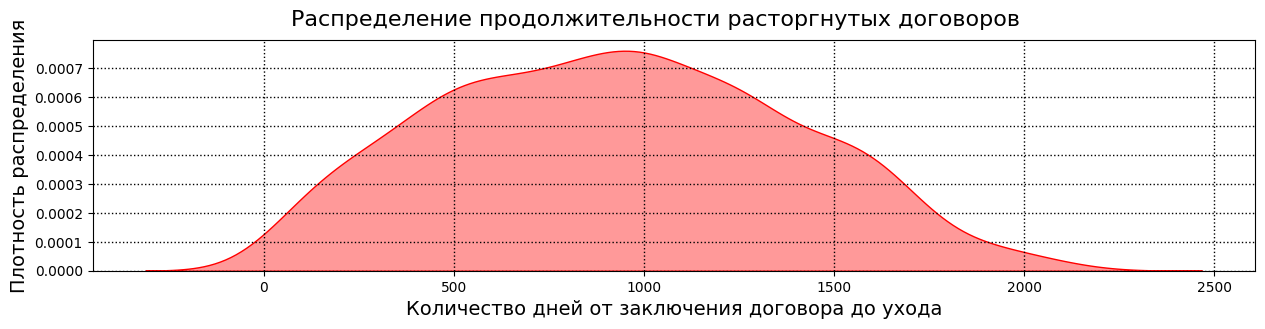

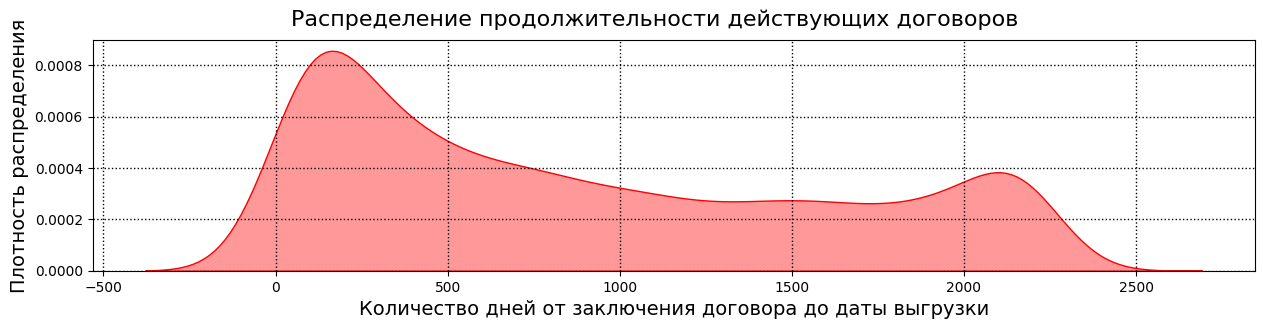

In [14]:
kdeplot(data=df.loc[df['target'] == 1]['contract_duration'],
        xlabel='Количество дней от заключения договора до ухода',
        figsize=(15, 3),
        suptitle='Распределение продолжительности расторгнутых договоров',
        ylabel='Плотность распределения')
kdeplot(data=df.loc[df['target'] == 0]['contract_duration'],
        xlabel='Количество дней от заключения договора до даты выгрузки',
        figsize=(15, 3),
        suptitle='Распределение продолжительности действующих договоров',
        ylabel='Плотность распределения')

plt.show()

Продолжительность расторгнутых договоров распределена нормально в диапазоне от 0 до 2000 дней, наиболее частая продолжительность - от 500 до 1500 дней. Среди действующих договоров заметно большое количество "молодых" договоров - до года, также заметно увеличенное колличество договоров со сроком около 2100 дней.

Проведём оценку распределения величин ежемесячных расходов и общих расходов среди ушедших и действующих пользователей.

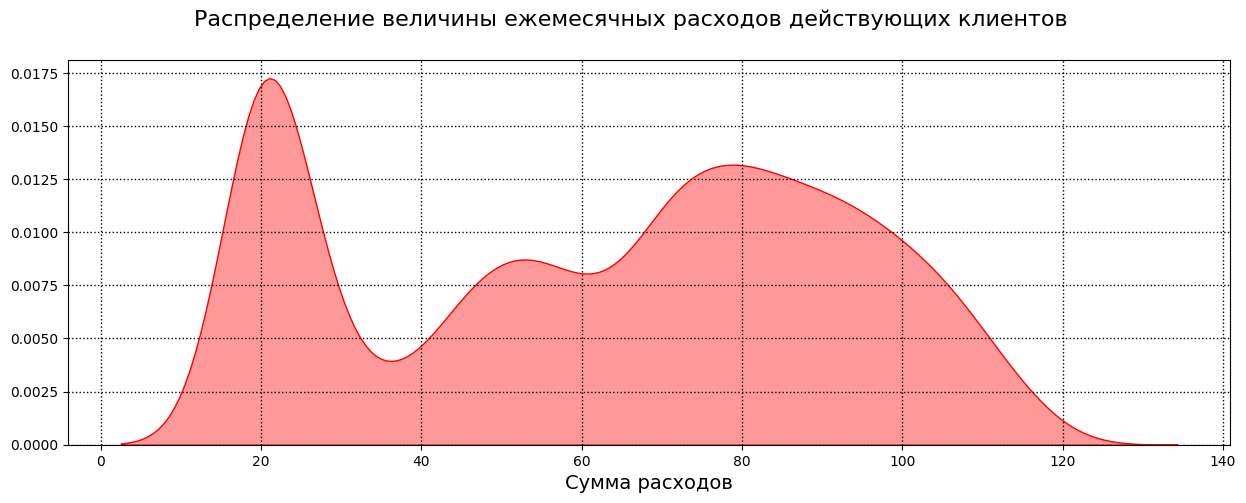

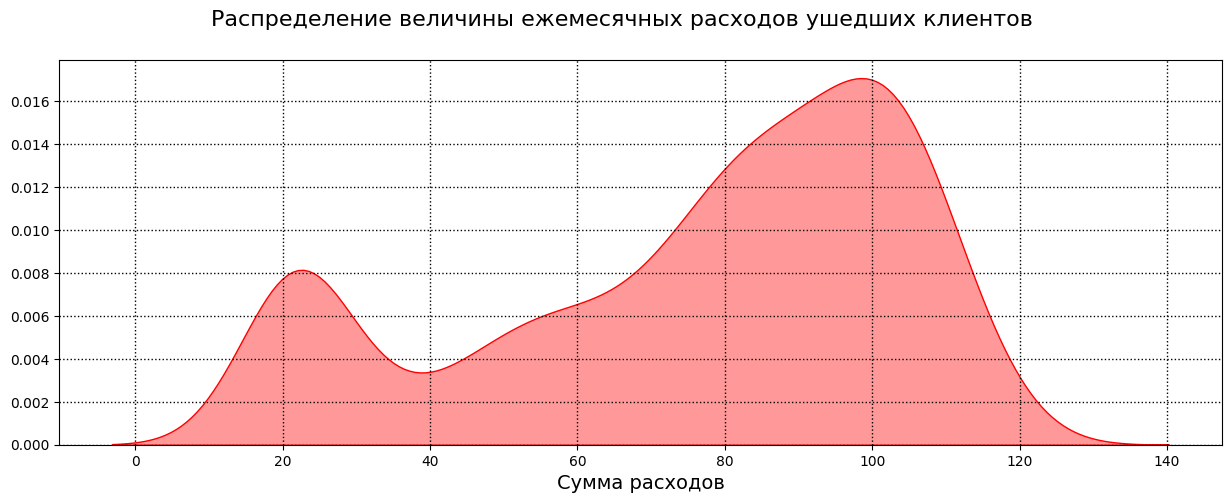

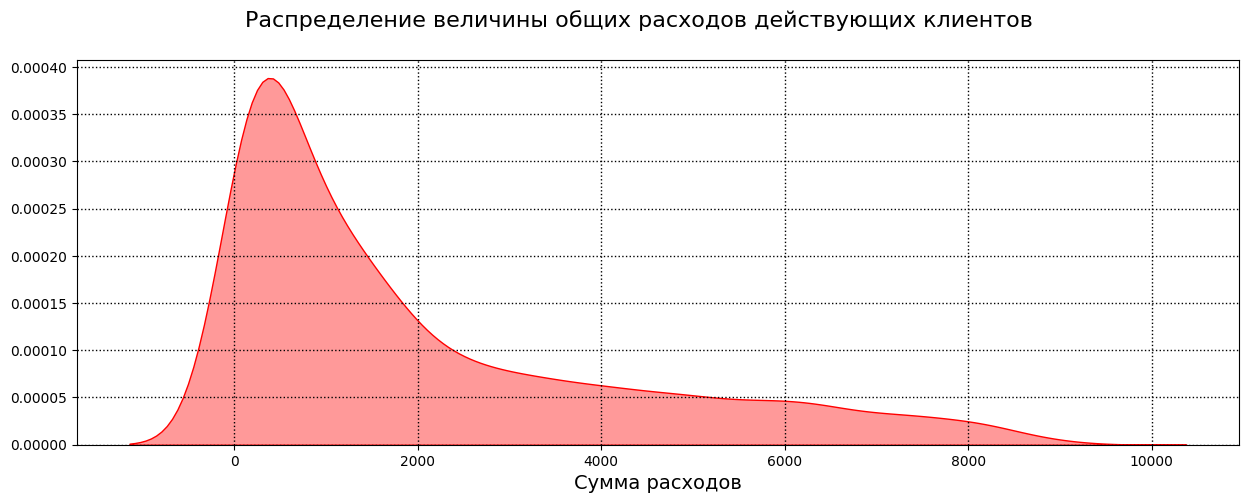

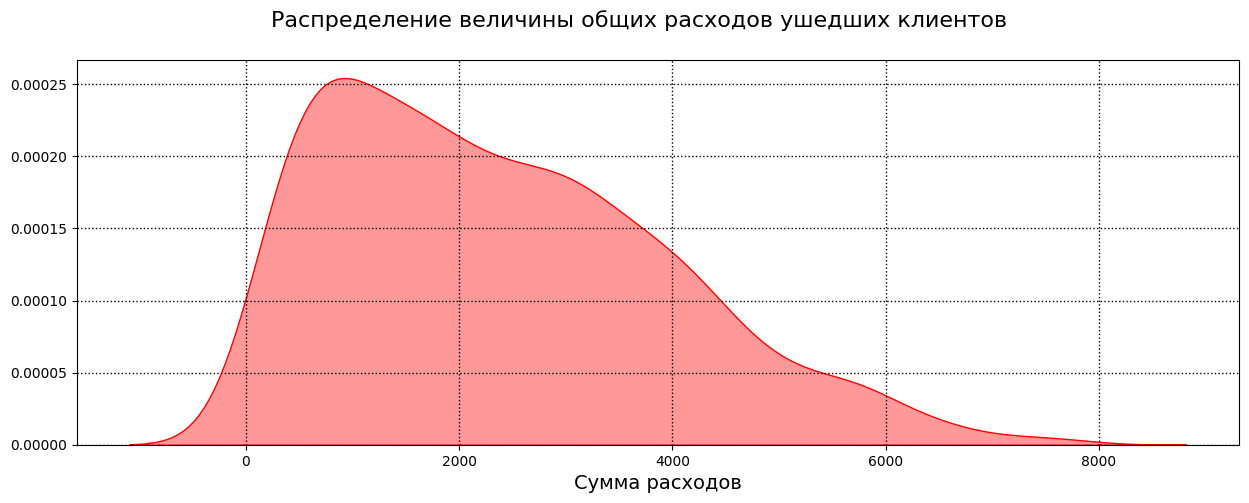

In [15]:
kdeplot(df[df['target'] == 0]['monthly_charges'], xlabel='Сумма расходов',figsize=(15, 5),
        suptitle='Распределение величины ежемесячных расходов действующих клиентов',
        ylabel='')
kdeplot(df[df['target'] == 1]['monthly_charges'], xlabel='Сумма расходов',figsize=(15, 5),
        suptitle='Распределение величины ежемесячных расходов ушедших клиентов',
        ylabel='')

kdeplot(df[df['target'] == 0]['total_charges'], xlabel='Сумма расходов',figsize=(15, 5),
        suptitle='Распределение величины общих расходов действующих клиентов',
        ylabel='')
kdeplot(df[df['target'] == 1]['total_charges'], xlabel='Сумма расходов',figsize=(15, 5),
        suptitle='Распределение величины общих расходов ушедших клиентов',
        ylabel='')

plt.show()

Сумма ежемесячных расходов у ушедших клиентов сильно смещена в сторону увеличения расходов, пик которых приходится на 100 у.е. Для действующих клиентов напротив, пик расходов приходится на ~20 у.е., вторая вершина приходится на ~80 у.е. Это говорит нам о том, что ушедшие клиенты тратили больше действующих. Возможно, действующие клиенты пользуются новыми более выгодными тарифами, или промо-тарифами, недоступными для старых клиентов.

Распределение суммарных расходов показывает, что действующие клиенты имеют чёткий пик расходов около 500 у.е., что может говорить нам о том, что они подключились примерно в одно время, скорее всего имела место рекламная компания, в рамках которой новым клиентам был предложен очень выгодный тариф.

Оценим приток новых пользователей по дате заключения договора.

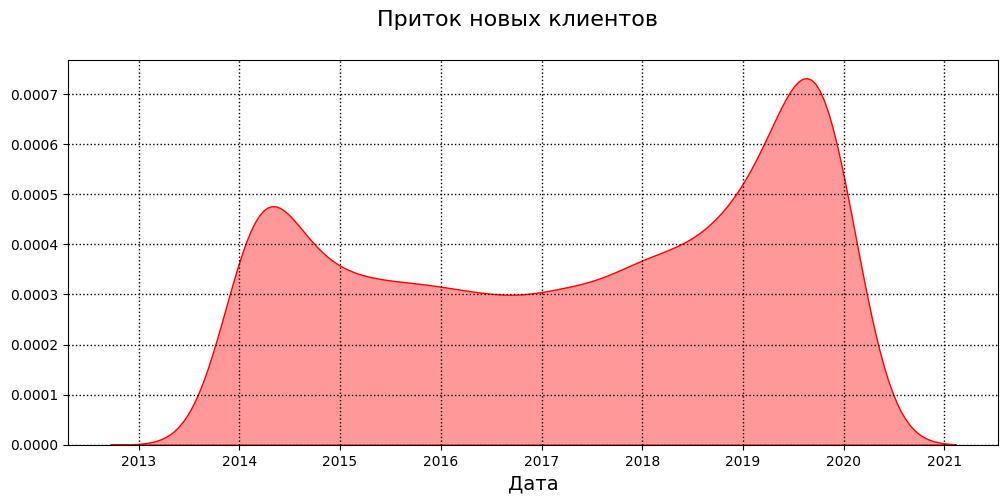

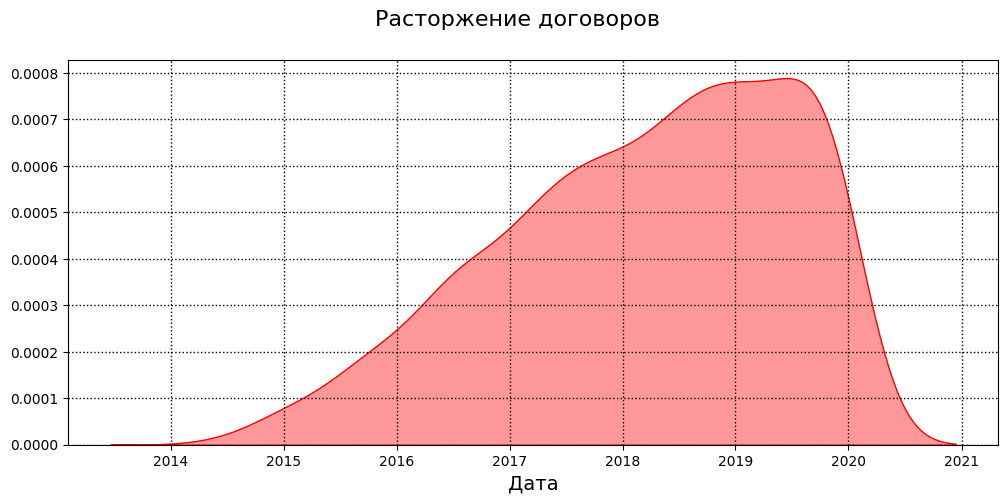

Дата заключения первого договора: 2013-10-01 00:00:00


In [16]:
kdeplot(df['begin_date'], xlabel='Дата',figsize=(12, 5),
        suptitle='Приток новых клиентов',
        ylabel='')
kdeplot(df[df['end_date'] != ACTUAL_DATE]['end_date'], xlabel='Дата',figsize=(12, 5),
        suptitle='Расторжение договоров',
        ylabel='')

plt.show()
print('Дата заключения первого договора:', df['begin_date'].min())

На представленном графике притока клиентов видны две вершины: первая - после старта работы провайдера в октябре 2013 года, вторая(и наибольшая) вершина заметная в моменте выгрузки данных. Данные пики привлечения новых клиентов скорее всего связаны с активными маркетинговыми компаниями.

График оттока клиентов демонстрирует равномерное увеличение расторгнутых договоров с течением времени, что может свидетельствовать о недостаточных усилях компании в отношении сохранения договоров с имеющимися пользователями.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'contract_duration']


<Axes: >

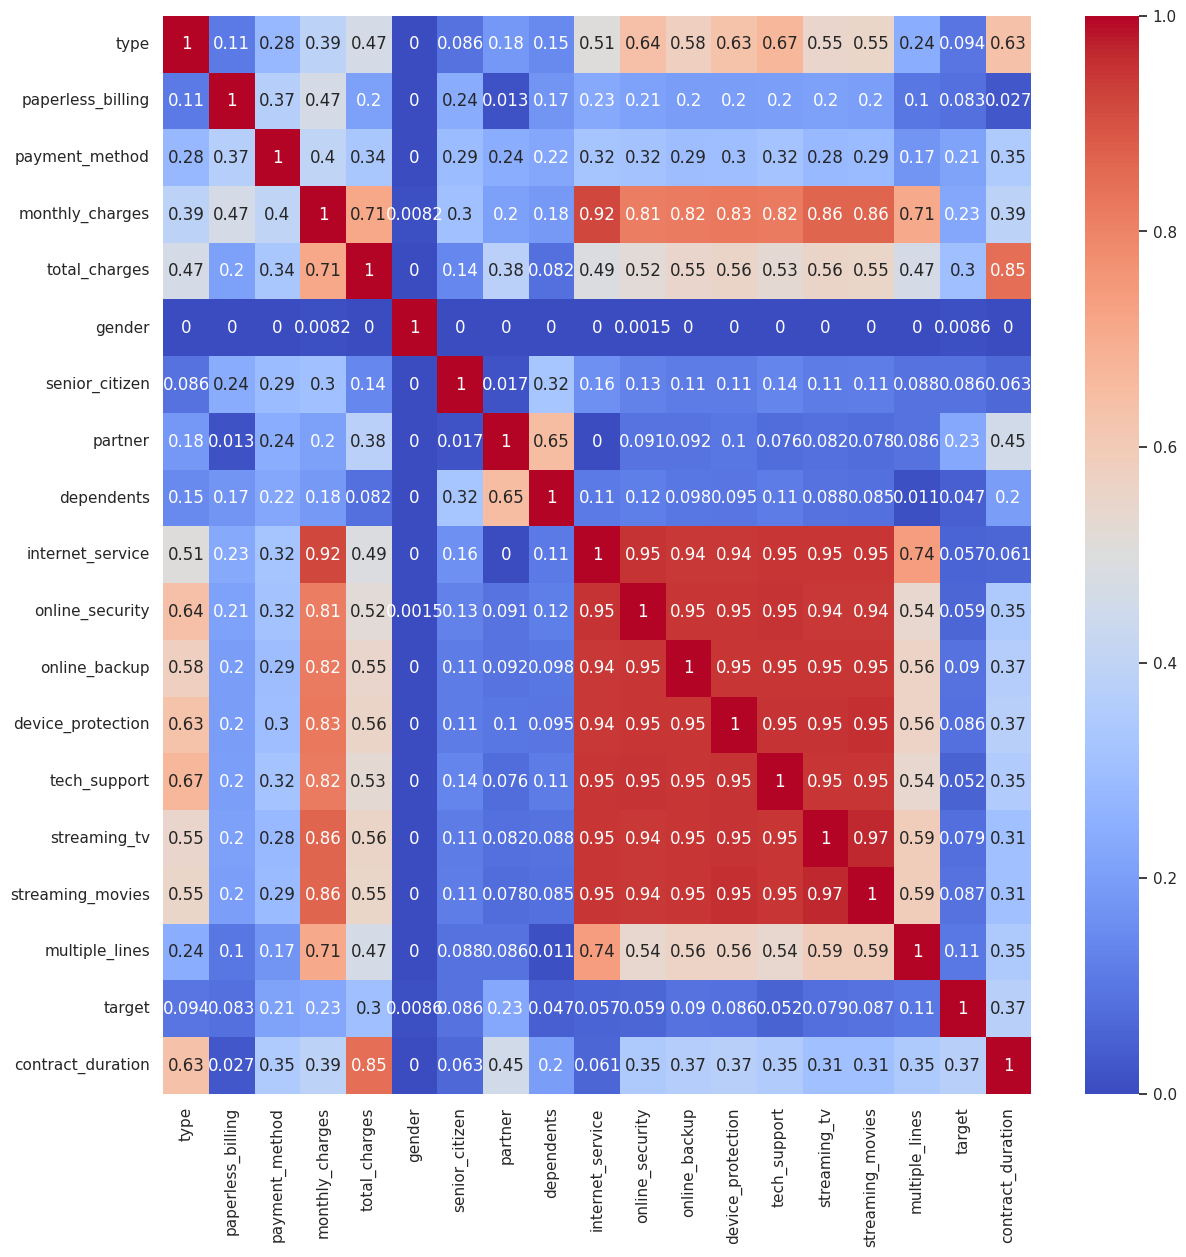

In [17]:
# Построим матрицу корреляции
phik = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1).phik_matrix()
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(phik, annot=True, cmap='coolwarm')

**Выводы:**

**Продолжительность расторгнутых договоров** распределена нормально в диапазоне **от 0 до 2000 дней**, наиболее частая продолжительность - от 500 до 1500 дней. **Среди действующих договоров заметно большое количество "молодых" договоров - до года**, также заметно увеличенное колличество договоров со сроком около 2100 дней.

**Сумма ежемесячных расходов у ушедших клиентов сильно смещена в сторону увеличения расходов**, пик которых приходится на 100 у.е. Для действующих клиентов напротив, пик расходов приходится на ~20 у.е., вторая вершина приходится на ~80 у.е. Это говорит нам о том, что **ушедшие клиенты тратили больше действующих**. Возможно, действующие клиенты пользуются новыми более выгодными тарифами, или промо-тарифами, недоступными для старых клиентов.

Распределение суммарных расходов показывает, что **действующие клиенты имеют чёткий пик расходов около 500 у.е.**, что может говорить нам о том, что **они подключились примерно в одно время**, скорее всего имела место рекламная компания, в рамках которой новым клиентам был предложен очень выгодный тариф.

Изучение числовых признаков показало, что **значительная часть пользователей тратит на услуги оператора маленькие суммы ежемесячно (около 20 у.е.)**. Также, есть достаточно большое количество новых пользователей, суммарные траты которых не превышают 500 у.е. Явных выбросов в данных, требующих устранения - не обнаружено.

На графике притока новых пользователей видны две вершины: первая - после старта работы провайдера в октябре 2013 года, вторая(и наибольшая) вершина заметная в моменте выгрузки данных. Данные **пики привлечения новых клиентов скорее всего связаны с активными маркетинговыми компаниями.**

График оттока клиентов демонстрирует равномерное увеличение расторгнутых договоров с течением времени, что может свидетельствовать о **недостаточных усилях компании в отношении сохранения договоров** с имеющимися пользователями.

Изучение матрицы корреляции признаков показало наличие мультиколлинеарности, однако используемые в проекте модели отлично справляются с этим явлением, что позволяет нам не избавляться от таких признаков. Также, мы можем отбросить признаки пола(gender) и наличия иждивенцев(dependents), так как они не имеют корреляции с другими признаками.

**По целевому признаку заметен сильный дисбаланс классов**, однако, в предполагаемых моделях МО есть встроенные алгоритмы для борьбы с этим явлением. Масштабирование признаков не проводилось, так как деревянные модели и бустинги не имеют проблем с работой на немасштабированных данных.

## Обучение моделей

### Подготовка выборок данных

In [18]:
# Удалим признаки старта и окончания договора в целях избежания утечки данных, а также customerID
df.drop(['customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

# Разобьём данные на тренировочные и тестовые
features_train, features_test, target_train, target_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, stratify=df['target'], random_state=RANDOM_STATE)

# Сбросим индексы
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

# Удаление неинформативных признаков
# drop_cols = ['online_security', 'device_protection', 'streaming_tv', 'tech_support',
#        'paperless_billing', 'dependents', 'gender', 'senior_citizen', 'total_charges']
drop_cols = ['dependents', 'gender']
features_train.drop(drop_cols, axis=1, inplace=True)
features_test.drop(drop_cols, axis=1, inplace=True)

# Сохраним список категориальных числовых признаков
NUM_FEATURES = ['monthly_charges', 'contract_duration', 'total_charges']
CAT_FEATURES = list(features_train.columns)

for feature in NUM_FEATURES:
    CAT_FEATURES.remove(feature)

for col in CAT_FEATURES:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

# Сделаем кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# Создадим копии датафреймов
features_train_coded = encoder.fit_transform(features_train[CAT_FEATURES].copy())
features_test_coded = encoder.transform(features_test[CAT_FEATURES].copy())

# Создание нового датафрейма с помощью pandas
features_train_encoded = pd.DataFrame(features_train_coded, columns=encoder.get_feature_names_out())
features_test_encoded = pd.DataFrame(features_test_coded, columns=encoder.get_feature_names_out())

# Присоединим числовые признаки
for feature in NUM_FEATURES:
    features_train_encoded[feature] = features_train[feature]
    features_test_encoded[feature] = features_test[feature]

In [19]:
# Проверим размерности выборок
print('Тренировочная выборка:')
print(features_train.shape)
print(features_train_encoded.shape)
print(target_train.shape)
print('Тестовая выборка:')
print(features_test.shape)
print(features_test_encoded.shape)
print(target_test.shape)

Тренировочная выборка:
(5282, 16)
(5282, 27)
(5282,)
Тестовая выборка:
(1761, 16)
(1761, 27)
(1761,)


In [20]:
# Функция для расчета времени выполнения ячейки
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return ("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Список для результатов проверки моделей на CV
results = {}

### Random Forest

**Здесь и далее, для всех моделей, подбор гиперпараметров закомментирован в целях экономии времени при повторном запуске ноутбука.**

Для модели RandomForest подбор гиперпараметров осуществлен случайным поиском по сетке параметров.

In [21]:
# # GridSearchCV
# parameters = {'max_depth': [4,6,8,10,12],
#               'n_estimators': [100,500,1000],
#              }

# # Осуществим подбор гиперпараметров по сетке в кросс-валидации для первой модели
# rfc_tuner = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),param_distributions=parameters,scoring=['roc_auc', 'accuracy'],cv=3,verbose=10, n_jobs=-1)
# rfc_tuner.fit(features_train_encoded, target_train)

In [22]:
# Параметры, подобранные с RandomizedSearchCV
rfc_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'random_state': RANDOM_STATE
}

In [23]:
# Создание модели RandomForest
rfc_model = RandomForestClassifier(**rfc_params)

# Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

# Создание экземпляра StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
rfc_cv_scores = pd.DataFrame(cross_validate(rfc_model, features_train_encoded, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


In [24]:
results['RandomForest'] = [rfc_cv_scores['test_roc_auc'].mean(),rfc_cv_scores['test_accuracy'].mean(),(rfc_cv_scores['fit_time'] + rfc_cv_scores['score_time']).mean()]

### Catboost

Для модели Catboost проведен подбор гиперпараметров с использованием Optuna, после чего модель проверена на кросс-валидации.

In [25]:
# # Подбор гиперпараметров с OPTUNA
# def objective(trial: optuna.Trial) -> float:
#     data, target = features_train, target_train
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

#     param = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, step=0.01),
#         "depth": trial.suggest_int("depth", 1, 10, step=1),
#         "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2, 10, step=1),
#         "iterations": trial.suggest_int("iterations", 400, 1900, step=100),
#         "subsample": trial.suggest_float("subsample", 0.05, 1, log=True),
#         "early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [False, 33]),
# #         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
# #         "bootstrap_type": trial.suggest_categorical(
# #             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
# #         ),
#         "eval_metric": "AUC",
#         "loss_function": "Logloss",
#         "cat_features": CAT_FEATURES
#     }

# #     if param["bootstrap_type"] == "Bayesian":
# #         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
# #     elif param["bootstrap_type"] == "Bernoulli":
# #         param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

#     gbm = cb.CatBoostClassifier(**param)

#     pruning_callback = CatBoostPruningCallback(trial, "AUC")
#     gbm.fit(
#         train_x,
#         train_y,
#         eval_set=[(valid_x, valid_y)],
#         verbose=0,
#         early_stopping_rounds=100,
#         callbacks=[pruning_callback],
#     )

#     # evoke pruning manually.
#     pruning_callback.check_pruned()

#     preds = gbm.predict_proba(valid_x)
#     #pred_labels = np.rint(preds)
#     scoring = roc_auc_score(valid_y, preds[:,1])

#     return scoring


# if __name__ == "__main__":
#     study = optuna.create_study(
#         pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize"
#     )
#     study.optimize(objective, n_trials=50, timeout=600)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [26]:
# Параметры, подобранные с Optuna
cb_params = {
    'learning_rate': 0.291,
    'depth': 3,
    'l2_leaf_reg': 7,
    'iterations': 1800,
    'subsample': 0.5959658804689887,
    'eval_metric': "AUC",
    'loss_function': "CrossEntropy",
    'custom_metric': "Accuracy",
    'silent': True
}

In [27]:
# Создание модели Catboost
cb_model = cb.CatBoostClassifier(**cb_params, cat_features=CAT_FEATURES)

# Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

# Создание экземпляра StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
cb_cv_scores = pd.DataFrame(cross_validate(cb_model, features_train, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   49.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [28]:
results['Catboost'] = [cb_cv_scores['test_roc_auc'].mean(),cb_cv_scores['test_accuracy'].mean(),(cb_cv_scores['fit_time'] + cb_cv_scores['score_time']).mean()]

### LightGBM

Для модели LightGBM проведен подбор гиперпараметров с использованием Optuna, после чего модель проверена на кросс-валидации.

In [29]:
# # Подбор гиперпараметров с OPTUNA
# def objective(trial: optuna.Trial) -> float:
#     data, target = features_train_encoded, target_train
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

#     param = {
#         "objective": "binary",
#         "metric": "auc",
#         "verbosity": -1,
#         "bagging_freq": 1,
#         "n_estimators": trial.suggest_int("n_estimators", 400, 1900, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
# #        "categorical_feature": "name:"+CAT_FEATURES
#     }

#     gbm = lgb.LGBMClassifier(**param)

#     pruning_callback = LightGBMPruningCallback(trial, "auc")
#     gbm.fit(
#         train_x,
#         train_y,
#         eval_set=[(valid_x, valid_y)],
#         verbose=0,
#         early_stopping_rounds=100,
#         callbacks=[pruning_callback],
#     )

#     preds = gbm.predict_proba(valid_x)
#     #pred_labels = np.rint(preds)
#     scoring = roc_auc_score(valid_y, preds[:,1])

#     return scoring


# if __name__ == "__main__":
#     study = optuna.create_study(
#         pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize"
#     )
#     study.optimize(objective, n_trials=50, timeout=600)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [30]:
# Параметры, подобранные с Optuna
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "bagging_freq": 1,
    "n_estimators": 600,
    "learning_rate": 0.48515779069632936,
    "num_leaves": 58,
    "subsample": 0.8573377073047915,
    "colsample_bytree": 0.05277300357899138,
    "min_data_in_leaf": 7,
    "random_state": RANDOM_STATE
}

In [31]:
# Создание модели LightGBM
lgb_model = lgb.LGBMClassifier(**lgb_params)

# Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

# Создание экземпляра StratifiedKFold с параметрами shuffle и stratify
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Вычисление ROC AUC и accuracy с использованием cross_val_score и заданными параметрами cv
lgb_cv_scores = pd.DataFrame(cross_validate(lgb_model, features_train_encoded, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.3s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


In [32]:
results['LightGBM'] = [lgb_cv_scores['test_roc_auc'].mean(),lgb_cv_scores['test_accuracy'].mean(),(lgb_cv_scores['fit_time'] + lgb_cv_scores['score_time']).mean()]

### XGBoost

Для модели XGBoost проведен подбор гиперпараметров с использованием Optuna, после чего модель проверена на кросс-валидации.

In [33]:
# # Подбор гиперпараметров с OPTUNA
# def objective(trial: optuna.Trial) -> float:
#     data, target = features_train, target_train
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

#     param = {
#         'max_depth': trial.suggest_int('max_depth', 1, 9),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'eval_metric': 'auc',
#         "objective": 'binary:logistic',
#         "tree_method": 'hist',
#         "enable_categorical": True
#     }

#     gbm = xgb.XGBClassifier(**param)

#     pruning_callback = XGBoostPruningCallback(trial, "validation_0-auc")
#     gbm.fit(
#         train_x,
#         train_y,
#         eval_set=[(valid_x, valid_y)],
#         verbose=0,
#         early_stopping_rounds=100,
#         callbacks=[pruning_callback],
#     )

#     preds = gbm.predict_proba(valid_x)
#     #pred_labels = np.rint(preds)
#     scoring = roc_auc_score(valid_y, preds[:,1])

#     return scoring


# if __name__ == "__main__":
#     study = optuna.create_study(
#         pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize"
#     )
#     study.optimize(objective, n_trials=150, timeout=600)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [34]:
# Параметры, подобранные с Optuna
xgb_params = {
    "max_depth": 5,
    "learning_rate": 0.0635387698008033,
    "n_estimators": 977,
    "min_child_weight": 7,
    "gamma": 0.00036224630752721115,
    "subsample": 0.9716881230818161,
    "colsample_bytree": 0.9792676267794214,
    "reg_alpha": 6.817367304791585e-08,
    "reg_lambda": 0.006974034314907304,
    "eval_metric": 'auc',
    "objective": 'binary:logistic',
    "tree_method": 'hist',
    "enable_categorical": True
}

In [35]:
# Создание модели XGBoost
xgb_model = xgb.XGBClassifier(**xgb_params)

# Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

# Создание экземпляра StratifiedKFold с параметрами shuffle и stratify
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Вычисление ROC AUC и accuracy с использованием cross_val_score и заданными параметрами cv
xgb_cv_scores = pd.DataFrame(cross_validate(xgb_model, features_train, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


In [36]:
results['XGBoost'] = [xgb_cv_scores['test_roc_auc'].mean(),xgb_cv_scores['test_accuracy'].mean(),(xgb_cv_scores['fit_time'] + xgb_cv_scores['score_time']).mean()]

### Dummy модель

In [37]:
# Сохраним время начала выполнения кода
start = time.time()

dummy_model = DummyClassifier(strategy='prior')
dummy_model.fit(features_train, target_train)

dummy_predictions = dummy_model.predict(features_test)
dummy_proba = dummy_model.predict_proba(features_test)

dummy_auc_roc = roc_auc_score(target_test, dummy_proba[:,1])
dummy_accuracy = accuracy_score(target_test, dummy_predictions)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
dummy_fit_time = exec_time(start, end)

results['Dummy'] = [dummy_auc_roc,\
                      dummy_accuracy,\
                      dummy_fit_time]

**Выводы:**

В данной части работы были подготовлены выборки для обучения моделей, в том числе, выделены категориальные признаки и их кодирование методом OHE. После чего были подобраны гиперпараметры и обучены на кросс-валидации четыре модели: RandomForest, Catboost, LightGBM и XGBoost. Результаты моделей сохранены и готовы к анализу.

## Оценка моделей

Посмотрим и проанализируем результаты всех моделей.

In [38]:
for elem in results:
    print(elem, 'ROC-AUC:', results[elem][0])
    print(elem, 'Accuracy:', results[elem][1])
    print(elem, 'Fitting time:', results[elem][2])
    print('- ' * 15)

RandomForest ROC-AUC: 0.8209818917814482
RandomForest Accuracy: 0.8563039333734699
RandomForest Fitting time: 1.5379979133605957
- - - - - - - - - - - - - - - 
Catboost ROC-AUC: 0.9207205404955557
Catboost Accuracy: 0.922569414581004
Catboost Fitting time: 32.43693199157715
- - - - - - - - - - - - - - - 
LightGBM ROC-AUC: 0.8967005997372824
LightGBM Accuracy: 0.9166983816404347
LightGBM Fitting time: 0.9145018577575683
- - - - - - - - - - - - - - - 
XGBoost ROC-AUC: 0.8857507697248398
XGBoost Accuracy: 0.8962533327599551
XGBoost Fitting time: 1.808979082107544
- - - - - - - - - - - - - - - 
Dummy ROC-AUC: 0.5
Dummy Accuracy: 0.8438387279954571
Dummy Fitting time: 00:00:00
- - - - - - - - - - - - - - - 


**Выводы:**

Модель RandomForest не смогла достичь целевого значения метрики AUC-ROC в 0.85. Все остальные модели справились отлично. Модель LightGBM показала отличное время обучения, быстрее в 2 раза, чем XGBoost и на порядки быстрее Catboost. В плане метрик, Catboost оказался заметно более результативным, чем все остальные модели, его метрика AUC-ROC составила 0.921 на кросс-валидации. Все модели отработали ожидаемо лучше Dummy модели.

## Тестирование модели

In [39]:
# Сохраним время начала выполнения кода
start = time.time()

# Обучим модель
cb_pool = cb.Pool(features_train, target_train, cat_features=CAT_FEATURES)
cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(cb_pool, verbose=False, plot=True)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cb_fit_time = exec_time(start, end)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
cb_predictions = cb_model.predict(features_test)
cb_predictions_proba = cb_model.predict_proba(features_test)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cb_pred_time = exec_time(start, end)

Cannot restore border parameter, falling to default border = 0.5


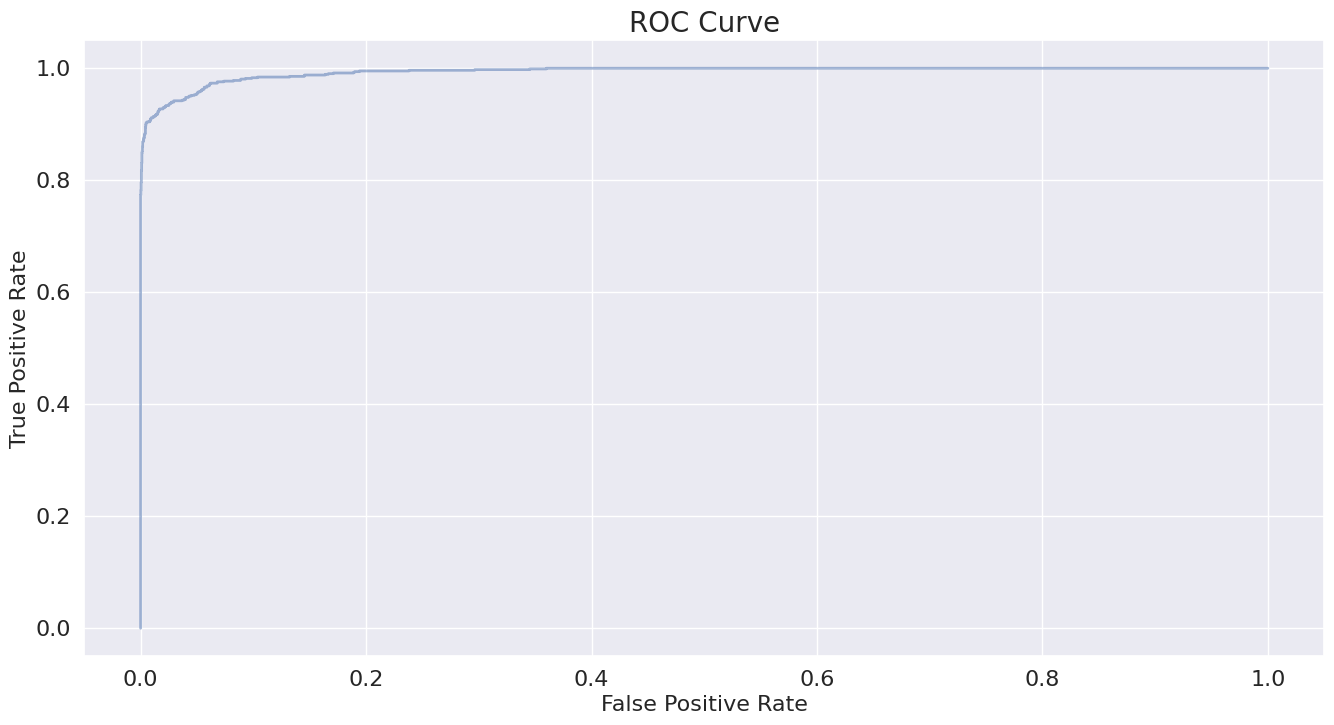

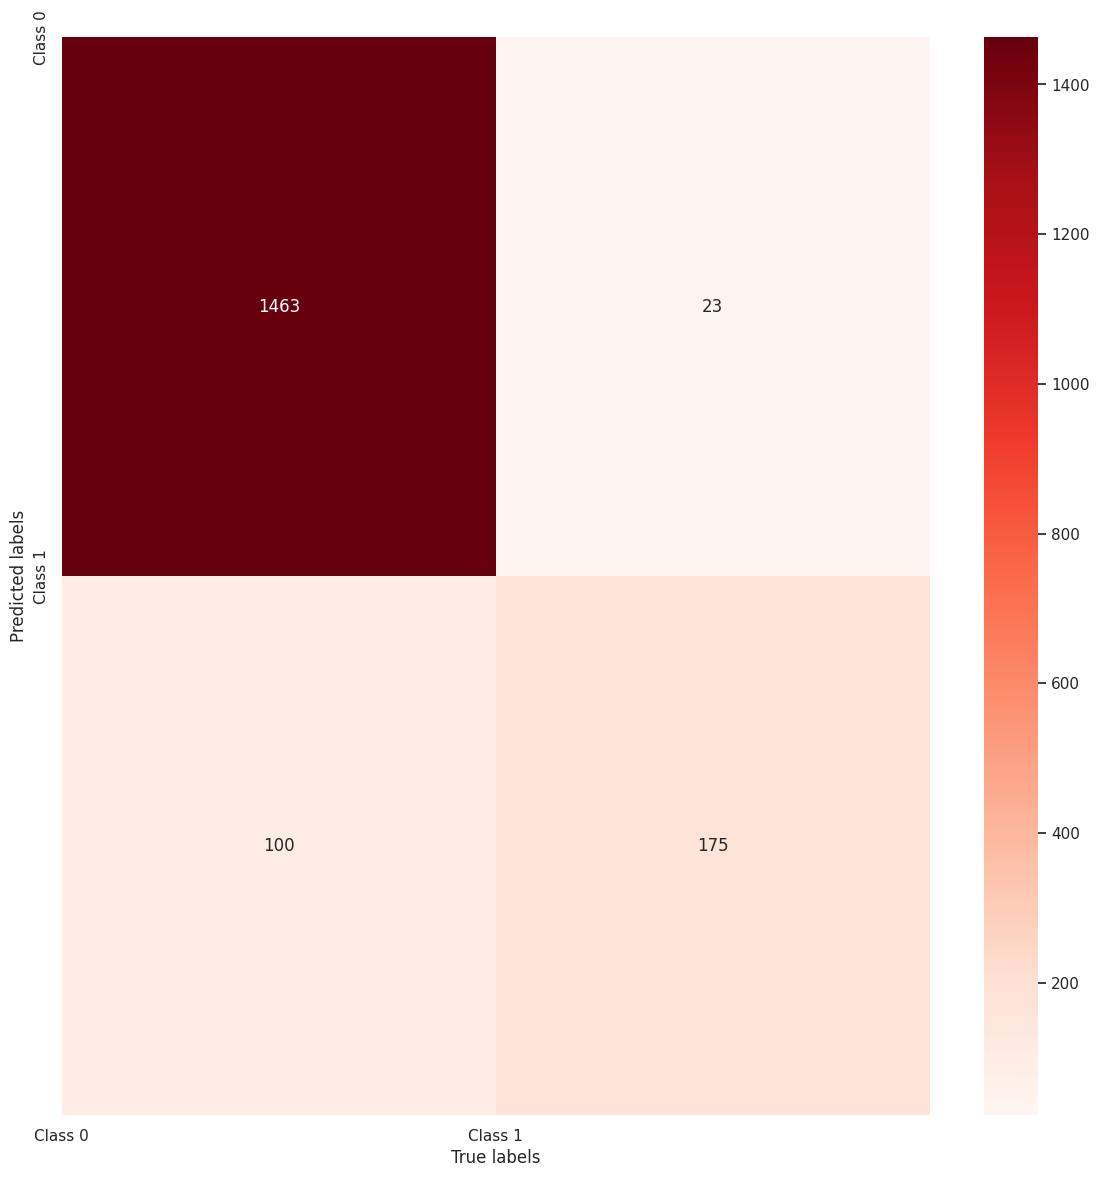

In [41]:
# Построим ROC-кривую
get_roc_curve(cb_model, cb_pool, plot=True)

# Отображение графика
plt.show()

# Построим матрицу ошибок модели
cm = get_confusion_matrix(cb_model, cb.Pool(features_test, target_test, cat_features=CAT_FEATURES))

# Создание тепловой карты для матрицы ошибок
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')

# Настройка осей и добавление меток классов
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])

# Отображение графика
plt.show()

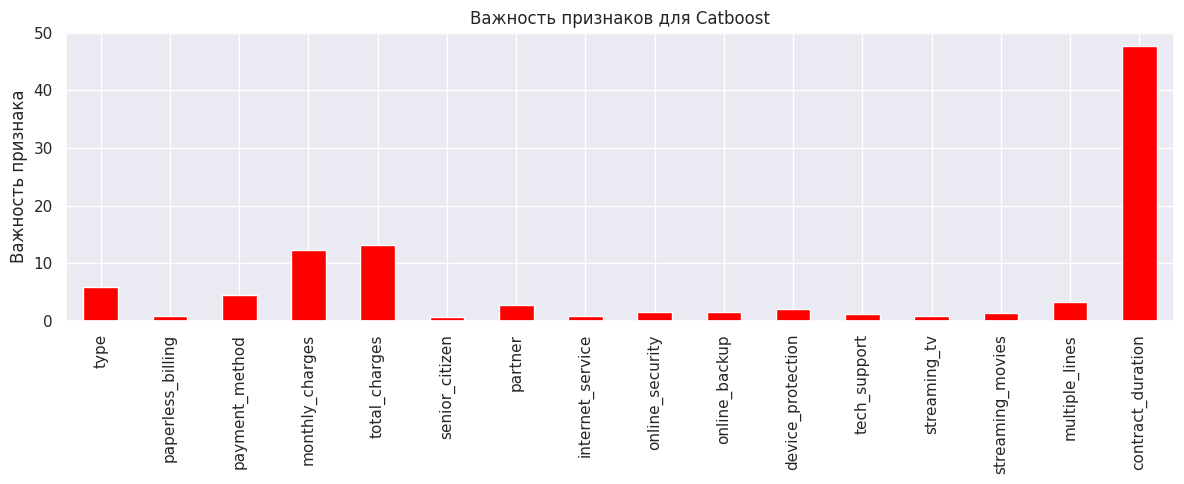

In [42]:
feature_importance_cb = cb_model.get_feature_importance()

feature_importance_cb = pd.Series(feature_importance_cb, index=features_test.columns)

plt.show()

fig, ax = plt.subplots(figsize=(12,5))

feature_importance_cb.plot.bar(ax=ax, color='red', grid=True)
ax.set_title("Важность признаков для Catboost")
ax.set_ylabel('Важность признака')
fig.tight_layout()

Протестируем модель с урезанным числом признаков и сравним результаты с исходными.

In [43]:
# Обрежем признаки, оставив только важные
CUTTED_FEATURES = ['type', 'payment_method', 'monthly_charges', 'total_charges', 'contract_duration', 'partner', 'multiple_lines']
CUTTED_CAT_FEATURES = ['type', 'payment_method', 'partner', 'multiple_lines']

features_train_cut = features_train[CUTTED_FEATURES]
features_test_cut = features_test[CUTTED_FEATURES]

# Сохраним время начала выполнения кода
start = time.time()

# Обучим модель
cut_cb_pool = cb.Pool(features_train_cut, target_train, cat_features=CUTTED_CAT_FEATURES)
cut_cb_model = cb.CatBoostClassifier(**cb_params)
cut_cb_model.fit(cut_cb_pool, verbose=False, plot=True)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cut_cb_fit_time = exec_time(start, end)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
cut_cb_predictions = cut_cb_model.predict(features_test_cut)
cut_cb_predictions_proba = cut_cb_model.predict_proba(features_test_cut)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cut_cb_pred_time = exec_time(start, end)

In [45]:
print('Исходные данные со всеми признаками:')
print('Catboost ROC-AUC:',roc_auc_score(target_test, cb_predictions_proba[:, 1]))
print('Catboost Accuracy:',accuracy_score(target_test, cb_predictions))
print('Catboost fitting time:', cb_fit_time)
print('Catboost prediction time:', cb_pred_time)
print('* ' * 25)
print('Данные с урезанными признаками:')
print('Catboost ROC-AUC:',roc_auc_score(target_test, cut_cb_predictions_proba[:, 1]))
print('Catboost Accuracy:',accuracy_score(target_test, cut_cb_predictions))
print('Catboost fitting time:', cut_cb_fit_time)
print('Catboost prediction time:', cut_cb_pred_time)
print('* ' * 25)

Исходные данные со всеми признаками:
Catboost ROC-AUC: 0.9094971246788205
Catboost Accuracy: 0.9301533219761499
Catboost fitting time: 00:00:30
Catboost prediction time: 00:00:00
* * * * * * * * * * * * * * * * * * * * * * * * * 
Данные с урезанными признаками:
Catboost ROC-AUC: 0.9131126881194176
Catboost Accuracy: 0.9324247586598523
Catboost fitting time: 00:00:13
Catboost prediction time: 00:00:00
* * * * * * * * * * * * * * * * * * * * * * * * * 


**Выводы:**

Модель Catboost показала стабильность на тестовых данных. **Метрика ROC-AUC: 0.913, Accuracy: 0.932, время обучения: 00:00:13.**

Модель сделала **100 ложно-негативных предсказаний и 23 ложно-положительных**. В целях данной работы для нас наиболее важны позитивные предсказания модели, чтобы компания могла осуществлять действия для удержания клиентов. Правильных позитивных предсказаний модель сделала 175.

**Важность признаков для модели**. Наиболее важными признаками являются длительность договора, суммарные траты, ежемесячные траты, тип договора по сроку, методы оплаты. Тестирование модели с урезанным числом признаков показало существенное **ускорение обучения модели на 23%**, метрика Accuracy увеличилась с 0.925 до 0.930, метрика **ROC-AUC увеличилась с 0.910 до 0.913**. В целом, можно констатировать, что **уменьшение числа признаков целесообразно.**

## Общие выводы

В ходе работы данные успешно загружены, клиентов, у которых нет никаких подключенных услуг не обнаружено.

**Продолжительность расторгнутых договоров** распределена нормально в диапазоне **от 0 до 2000 дней**, наиболее частая продолжительность - от 500 до 1500 дней. **Среди действующих договоров заметно большое количество "молодых" договоров - до года**, также заметно увеличенное колличество договоров со сроком около 2100 дней.

**Сумма ежемесячных расходов у ушедших клиентов сильно смещена в сторону увеличения расходов**, пик которых приходится на 100 у.е. Для действующих клиентов напротив, пик расходов приходится на ~20 у.е., вторая вершина приходится на ~80 у.е. Это говорит нам о том, что **ушедшие клиенты тратили больше действующих**. Возможно, действующие клиенты пользуются новыми более выгодными тарифами, или промо-тарифами, недоступными для старых клиентов.

Распределение суммарных расходов показывает, что **действующие клиенты имеют чёткий пик расходов около 500 у.е.**, что может говорить нам о том, что **они подключились примерно в одно время**, скорее всего имела место рекламная компания, в рамках которой новым клиентам был предложен очень выгодный тариф.

Изучение числовых признаков показало, что **значительная часть пользователей тратит на услуги оператора маленькие суммы ежемесячно (около 20 у.е.)**. Также, есть достаточно большое количество новых пользователей, суммарные траты которых не превышают 500 у.е. Явных выбросов в данных, требующих устранения - не обнаружено.

На графике притока новых пользователей видны две вершины: первая - после старта работы провайдера в октябре 2013 года, вторая(и наибольшая) вершина заметная в моменте выгрузки данных. Данные **пики привлечения новых клиентов скорее всего связаны с активными маркетинговыми компаниями.**

График оттока клиентов демонстрирует равномерное увеличение расторгнутых договоров с течением времени, что может свидетельствовать о **недостаточных усилях компании в отношении сохранения договоров** с имеющимися пользователями.

Изучение матрицы корреляции признаков показало наличие мультиколлинеарности, однако используемые в проекте модели отлично справляются с этим явлением, что позволяет нам не избавляться от таких признаков. Также, мы можем отбросить признаки пола(gender) и наличия иждивенцев(dependents), так как они не имеют корреляции с другими признаками.

**По целевому признаку заметен сильный дисбаланс классов**, однако, в предполагаемых моделях МО есть встроенные алгоритмы для борьбы с этим явлением. Масштабирование признаков не проводилось, так как деревянные модели и бустинги не имеют проблем с работой на немасштабированных данных.

Следующим этапом были подготовлены выборки для обучения моделей, в том числе, выделены категориальные признаки и их кодирование методом OHE. После чего были подобраны гиперпараметры и обучены на кросс-валидации четыре модели: **RandomForest, Catboost, LightGBM и XGBoost**.

Модель RandomForest не смогла достичь целевого значения метрики AUC-ROC в 0.85. Все остальные модели справились отлично. Модель LightGBM показала отличное время обучения, быстрее в 6 раз, чем XGBoost и на порядки быстрее Catboost. В плане метрик, Catboost оказался заметно более результативным, чем все остальные модели, его метрика AUC-ROC составила 0.918 на кросс-валидации.

Модель Catboost показала стабильность на тестовых данных. **Метрика ROC-AUC: 0.913, Accuracy: 0.932, время обучения: 00:00:13.**

Модель сделала **100 ложно-негативных предсказаний и 23 ложно-положительных**. В целях данной работы для нас наиболее важны позитивные предсказания модели, чтобы компания могла осуществлять действия для удержания клиентов. Правильных позитивных предсказаний модель сделала 175.

**Важность признаков для модели**. Наиболее важными признаками являются длительность договора, суммарные траты, ежемесячные траты, тип договора по сроку, методы оплаты. Тестирование модели с урезанным числом признаков показало существенное **ускорение обучения модели на 23%**, метрика Accuracy увеличилась с 0.925 до 0.930, метрика **ROC-AUC увеличилась с 0.910 до 0.913**. В целом, можно констатировать, что **уменьшение числа признаков целесообразно.**

По итогам работы, можно рекомендовать модель к использованию, её применение поможет сохранять лояльных клиентов компании. В дальнейшем следует проводить исследования с целью дальнейшей минимизации ложно негативных предсказаний модели.

# Отчет о проделанной работе.
Изначальный план работы предполагал следующие действия:
1. Подготовка данных. Загрузка и предварительная обработка данных.
2. Исследовательский анализ данных.
3. Обучение моделей. Обучение нескольких моделей машинного обучения, включая "деревянные модели" и бустинги.
4. Оценка качества моделей.
5. Тестирование лучшей модели. Проверка выбранной лучшей модели на тестовых данных.
6. Общие выводы.

Все работы были выполнены согласно данного плана, новых действий не потребовалось. Из затруднений в ходе работы хочу отметить, что по невнимательности не обратил внимания на тот нюанс, что метрика ROC-AUC вычисляется не по предсказаниям модели, а по предсказанным вероятностям классов. Пришлось потратить много времени, т.к. метрика ROC-AUC упорно не росла выше 0.83 на тестовых данных. После исправления расчета метрики, всё наладилось. 

Ключевыми этапами работы можно выделить предварительную обработку данных и подбор гиперпараметров с помощью Optuna. 

Далее, отмечу важные технические нюансы работы.

0. Константы для работы: RANDOM_STATE = 30723; ACTUAL_DATE = '2020-02-01' . Первая для сохранения воспроизводимости вычислений, вторая - дата выгрузки данных из БД.
1. Предварительная обработка данных. На данном этапе были произведены следующие манипуляции с исходными данными. Загруженные csv файлы объединены в один методом merge, с параметром on='left' по полю 'customerID'. Для колонок интернет-признаков ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService'] пропуски заполнены на 'no_internet', а для колонки MultipleLines - на 'no_phone'. Создан целевой признак по полю EndDate, если оно равно 'No', то target = 0, иначе target = 1. После чего 'No' в колонке EndDate заменен на дату выгрузки данных. Создан новый признак contract_duration, содержащий разницу в днях между BeginDate и EndDate. После чего, признаки с датами были удалены, чтобы избежать утечки данных при обучении моделей. Также был удален признак CustomerID, который не является информативным в целях обучения моделей ML. Для колонки 'TotalCharges' изменен тип данных на числовой, с заменой пропусков нулями, далее приравнены итоговые траты к месячным, если они меньше.
2. Разбиение данных на выборки произведено со стратификацией и соотношением тренировочных данных к тестовым 75:25.  После чего сброшены индексы, убраны колонки Dependents и Gender. На полученных выборках сделано кодирование методом OHE для моделей LightGBM и RandomForest. Полученные размерности выборок:
- Тренировочная выборка: тренировочная(5282, 16)тренировочная с OHE(5282, 27)таргет(5282,)
- Тестовая выборка:тренировочная(1761, 16)тренировочная с OHE(1761, 27)таргет(1761,)
3. Итоговой моделью стал классификатор Catboost, с гиперпараметрами, указанными для удобства в следющей ячейке. Данная модель обучена на урезанном наборе признаков после анализа их важности, список признаков: ['type', 'payment_method', 'monthly_charges', 'total_charges', 'contract_duration', 'partner', 'multiple_lines'].
4. Данная модель смогла достичь следующих показателей: **Метрика ROC-AUC: 0.913, Accuracy: 0.932, время обучения: 00:00:13.**